In [ ]:
!pip install datasets
!pip install evaluate

In [ ]:
#------------------------------------------------------------------------------
# Imports
#------------------------------------------------------------------------------

from datasets import load_dataset, Dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline, TrainingArguments, Trainer, AutoModel
import evaluate
import numpy as np
import torch
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP
from sklearn.cluster import KMeans
import matplotlib.cm as cm

# **3.1: Hands on the Dataset + Define Evaluation Metrics**

In [ ]:
#------------------------------------------------------------------------------
# Load Data
#------------------------------------------------------------------------------

# Mount Google Drive to access files (adjust or remove if running locally)
from google.colab import drive
drive.mount('/content/drive')

# # Load training, test, and label data from Parquet files (adjust paths if needed)
train_df = pd.read_parquet("/content/drive/MyDrive/SS25/MDS4AT/04_AbstractClassification/HuggingFaceData/train.parquet")
test_df = pd.read_parquet("/content/drive/MyDrive/SS25/MDS4AT/04_AbstractClassification/HuggingFaceData/test.parquet")
labels_df = pd.read_parquet("/content/drive/MyDrive/SS25/MDS4AT/04_AbstractClassification/HuggingFaceData/labels.parquet")

# Quick check: Display first few rows of each DataFrame
print(train_df.head())
print(test_df.head())
print(labels_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   condition_label                                   medical_abstract
0                5  Tissue changes around loose prostheses. A cani...
1                1  Neuropeptide Y and neuron-specific enolase lev...
2                2  Sexually transmitted diseases of the colon, re...
3                1  Lipolytic factors associated with murine and h...
4                3  Does carotid restenosis predict an increased r...
   condition_label                                   medical_abstract
0                3  Obstructive sleep apnea following topical orop...
1                5  Neutrophil function and pyogenic infections in...
2                5  A phase II study of combined methotrexate and ...
3                1  Flow cytometric DNA analysis of parathyroid tu...
4                4  Paraneoplastic vasculitic neuropathy: a treata...
   condition_label             

In [ ]:
#------------------------------------------------------------------------------
# Rename Labels & Build Label Mapping
#------------------------------------------------------------------------------

# Rename "condition_label" column to "label"
train_df = train_df.rename(columns={"condition_label": "label"})
test_df = test_df.rename(columns={"condition_label": "label"})

# Adjust label values from [1..5] to [0..4]
train_df["label"] = train_df["label"] - 1
test_df["label"] = test_df["label"] - 1

# Create mapping dictionary
labels_df["condition_label"] = labels_df["condition_label"] - 1
label_mapping = labels_df.set_index("condition_label")["condition_name"].to_dict()

# Quick check: show updated DataFrames and label mapping
print(train_df.head())
print(test_df.head())
print(label_mapping)

# Convert Pandas DataFrames to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

   label                                   medical_abstract
0      4  Tissue changes around loose prostheses. A cani...
1      0  Neuropeptide Y and neuron-specific enolase lev...
2      1  Sexually transmitted diseases of the colon, re...
3      0  Lipolytic factors associated with murine and h...
4      2  Does carotid restenosis predict an increased r...
   label                                   medical_abstract
0      2  Obstructive sleep apnea following topical orop...
1      4  Neutrophil function and pyogenic infections in...
2      4  A phase II study of combined methotrexate and ...
3      0  Flow cytometric DNA analysis of parathyroid tu...
4      3  Paraneoplastic vasculitic neuropathy: a treata...
{0: 'neoplasms', 1: 'digestive system diseases', 2: 'nervous system diseases', 3: 'cardiovascular diseases', 4: 'general pathological conditions'}


In [ ]:
#------------------------------------------------------------------------------
# Quick inspection
#------------------------------------------------------------------------------

sample_idx = 0

print("Sample abstract:")
print(train_ds[sample_idx]["medical_abstract"])

print("\nSample label:")
print(train_ds[sample_idx]["label"], "→", label_mapping[train_ds[sample_idx]["label"]])

Sample abstract:
Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic intervent

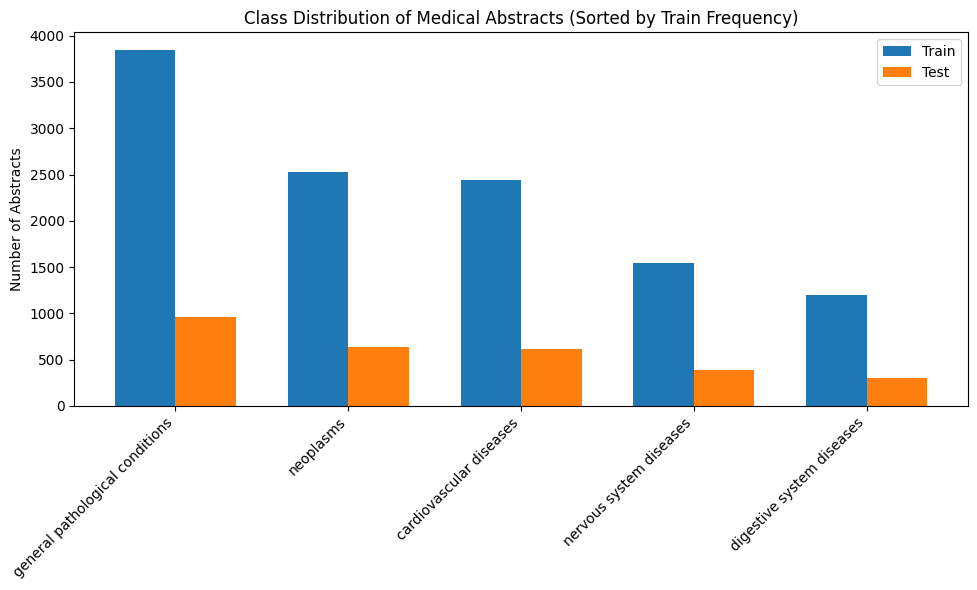

In [ ]:
#------------------------------------------------------------------------------
# Plot class distribution
#------------------------------------------------------------------------------

# Add human-readable label names to DataFrames
train_df["label_name"] = train_df["label"].map(label_mapping)
test_df["label_name"] = test_df["label"].map(label_mapping)

# Count number of samples per class
train_counts = train_df["label_name"].value_counts()
test_counts = test_df["label_name"].value_counts()

# Sort labels by descending frequency in the training set
sorted_labels = train_counts.sort_values(ascending=False).index.tolist()

# Align values for plotting (ensure same label order in both sets)
train_values = train_counts[sorted_labels]
test_values = test_counts.reindex(sorted_labels, fill_value=0)  # fill missing labels with 0

# Plot
x = range(len(sorted_labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, train_values, width=width, label="Train")
plt.bar([i + width for i in x], test_values, width=width, label="Test")
plt.xticks([i + width/2 for i in x], sorted_labels, rotation=45, ha='right')
plt.ylabel("Number of Abstracts")
plt.title("Class Distribution of Medical Abstracts (Sorted by Train Frequency)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#------------------------------------------------------------------------------
# Evaluation helper (given)
#------------------------------------------------------------------------------

def evaluate_performance(y_true, y_pred, label_mapping):
    """
    Print a sklearn classification_report for labels 0..4,
    using `label_mapping` to show human-readable class names.
    """
    labels = list(range(len(label_mapping)))  # [0,1,2,3,4]
    target_names = [label_mapping[i] for i in labels]

    print(classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=target_names
    ))

In [ ]:
#---------------------------------------------------------------------------------
# 1st Approach: Classification using Representation Models (without Fine-Tuning)
#---------------------------------------------------------------------------------

# Load PubMedBERT model and tokenizer
model = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

# Define Hugging Face pipeline for text classification
pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
    truncation=True,
    max_length=512,
    device=0  # for GPU
)

# Apply model to test set
test_texts = test_df["medical_abstract"].tolist()
predictions = pipe(test_texts, batch_size=16)

# Extract predicted labels
y_pred = [np.argmax([score["score"] for score in sample]) for sample in predictions]
y_true = test_df["label"].tolist()

# Evaluate classification performance
evaluate_performance(y_true, y_pred, label_mapping)

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0


                                 precision    recall  f1-score   support

                      neoplasms       0.22      1.00      0.36       633
      digestive system diseases       0.00      0.00      0.00       299
        nervous system diseases       0.00      0.00      0.00       385
        cardiovascular diseases       0.00      0.00      0.00       610
general pathological conditions       0.00      0.00      0.00       961

                       accuracy                           0.22      2888
                      macro avg       0.04      0.20      0.07      2888
                   weighted avg       0.05      0.22      0.08      2888



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#--------------------------------------------------------------------------------------------------------------
# 1st Approach: Classification using Representation Models (with Fine-Tuning); PLEASE DO NOT RUN this section
#--------------------------------------------------------------------------------------------------------------

import os
os.environ["WANDB_DISABLED"] = "true" # Disable Weights & Biases logging

# Load pretrained PubMedBERT model and tokenizer
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=label_mapping,
    label2id={v: k for k, v in label_mapping.items()}
)

# Define tokenization function
def tokenize_function(example):
    return tokenizer(
        example["medical_abstract"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Tokenize datasets
train_ds_tokenized = train_ds.map(tokenize_function, batched=True)
test_ds_tokenized = test_ds.map(tokenize_function, batched=True)

# Format datasets for PyTorch Trainer
train_ds_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Define training configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)

# Initialize HuggingFace Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tokenized,
    eval_dataset=test_ds_tokenized
)

# Start fine-tuning
trainer.train()

# Run inference on test data
predictions = trainer.predict(test_ds_tokenized)

y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

# Evaluate classification performance
evaluate_performance(y_true, y_pred, label_mapping)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/11550 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.928000,0.800302
2,0.756800,0.800431


Epoch,Training Loss,Validation Loss
1,0.928000,0.800302
2,0.756800,0.800431
3,0.623300,0.822237


                                 precision    recall  f1-score   support

                      neoplasms       0.69      0.81      0.75       633
      digestive system diseases       0.53      0.66      0.59       299
        nervous system diseases       0.59      0.66      0.62       385
        cardiovascular diseases       0.68      0.82      0.74       610
general pathological conditions       0.63      0.41      0.49       961

                       accuracy                           0.64      2888
                      macro avg       0.63      0.67      0.64      2888
                   weighted avg       0.64      0.64      0.63      2888



In [ ]:
#---------------------------------------------------------------------------------
# 2nd Approach: Classification using Embeddings (Supervised Classification)
#---------------------------------------------------------------------------------

# Extract texts and labels from train and test sets
train_texts = train_df["medical_abstract"].tolist()
test_texts = test_df["medical_abstract"].tolist()

y_train = train_df["label"].tolist()
y_test = test_df["label"].tolist()

# Load SentenceTransformer model
model_emb = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

# Encode abstracts into dense vectors (embeddings)
train_embeddings = model_emb.encode(train_texts, show_progress_bar=True)
test_embeddings = model_emb.encode(test_texts, show_progress_bar=True)

# Train simple classifier on top of embeddings (here: Logistic Regression)
clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings, y_train)

# Predict labels for test set
y_pred = clf.predict(test_embeddings)

# Evaluate classification performance
evaluate_performance(y_test, y_pred, label_mapping)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/361 [00:00<?, ?it/s]

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

                                 precision    recall  f1-score   support

                      neoplasms       0.67      0.73      0.70       633
      digestive system diseases       0.48      0.51      0.49       299
        nervous system diseases       0.55      0.49      0.52       385
        cardiovascular diseases       0.65      0.70      0.67       610
general pathological conditions       0.47      0.43      0.45       961

                       accuracy                           0.57      2888
                      macro avg       0.56      0.57      0.57      2888
                   weighted avg       0.56      0.57      0.57      2888



In [ ]:
#---------------------------------------------------------------------------------
# 2nd Approach: Classification using Embeddings (zero-shot Classification)
#---------------------------------------------------------------------------------

# Load SentenceTransformer model
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

# Extract label texts (class descriptions) from label mapping
label_texts = list(label_mapping.values())
label_ids = list(label_mapping.keys())

# Get test data and corresponding true labels
test_texts = test_df["medical_abstract"].tolist()
y_true = test_df["label"].tolist()

# Compute sentence embeddings for both abstracts and label texts
test_embeddings = model.encode(test_texts, show_progress_bar=True, convert_to_numpy=True)
label_embeddings = model.encode(label_texts, show_progress_bar=True, convert_to_numpy=True)

# Compute cosine similarity
similarities = cosine_similarity(test_embeddings, label_embeddings)

# Predict the label with the highest similarity score
y_pred = np.argmax(similarities, axis=1)

# Evaluate classification performance
evaluate_performance(y_true, y_pred, label_mapping)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

                                 precision    recall  f1-score   support

                      neoplasms       0.55      0.79      0.65       633
      digestive system diseases       0.42      0.49      0.46       299
        nervous system diseases       0.53      0.34      0.41       385
        cardiovascular diseases       0.54      0.80      0.64       610
general pathological conditions       0.48      0.24      0.32       961

                       accuracy                           0.52      2888
                      macro avg       0.50      0.53      0.50      2888
                   weighted avg       0.51      0.52      0.49      2888



Batches:   0%|          | 0/361 [00:00<?, ?it/s]

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


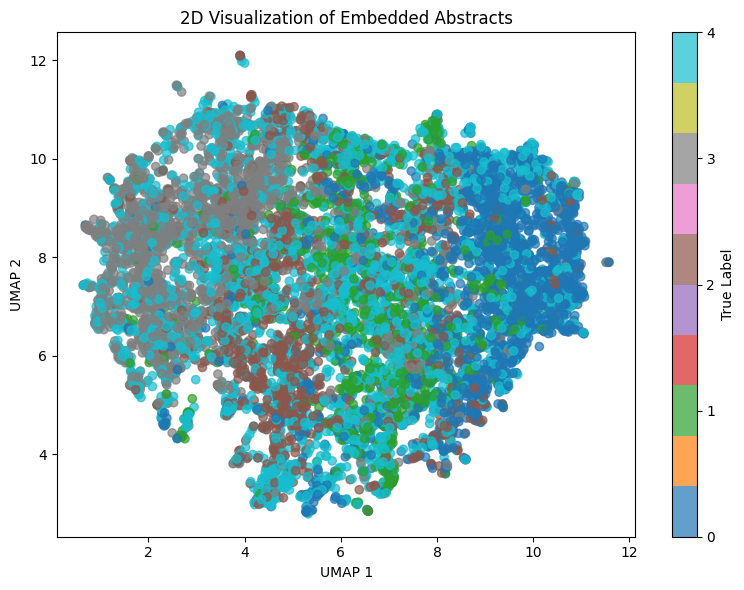

                                 precision    recall  f1-score   support

                      neoplasms       0.62      0.74      0.68       633
      digestive system diseases       0.37      0.43      0.40       299
        nervous system diseases       0.50      0.47      0.49       385
        cardiovascular diseases       0.55      0.65      0.60       610
general pathological conditions       0.45      0.33      0.38       961

                       accuracy                           0.52      2888
                      macro avg       0.50      0.53      0.51      2888
                   weighted avg       0.51      0.52      0.51      2888



In [ ]:
#---------------------------------------------------------------------------------
# 4th Approach: Classification using Text Clustering and Topic Modelling
#---------------------------------------------------------------------------------

from sklearn.neighbors import KNeighborsClassifier

# # Load texts and true labels from train and test sets
train_texts = train_df["medical_abstract"].tolist()
test_texts = test_df["medical_abstract"].tolist()
y_true = test_df["label"].tolist()

# Embed abstracts using SentenceTransformer
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")
train_embeddings = model.encode(train_texts, show_progress_bar=True)
test_embeddings = model.encode(test_texts, show_progress_bar=True)

# Reduce dimensionality by using UMAP
umap = UMAP(n_components=5, random_state=42)
train_reduced = umap.fit_transform(train_embeddings)
test_reduced = umap.transform(test_embeddings)

# Apply unsupervised clustering (K-Means)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(train_reduced)

# Visualization in 2D
umap_2d = UMAP(n_components=2, random_state=42)
train_2d = umap_2d.fit_transform(train_embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_2d[:, 0], train_2d[:, 1], c=train_df["label"], cmap="tab10", alpha=0.7)
plt.colorbar(scatter, ticks=range(5), label="True Label")
plt.title("2D Visualization of Embedded Abstracts")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

# Train k-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_reduced, train_df["label"])
y_pred = knn.predict(test_reduced)

# Evaluate classification perfomance
evaluate_performance(y_true, y_pred, label_mapping)